# AGH Modelling of Physical Systems Lab 6
Tomasz Makowski

In [22]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from open_atmos_jupyter_utils import show_plot

**Monte-Carlo Advection Solver 2D**

In [23]:
NX, NY = 32, 32
x = np.linspace(0, 1, NX)
y = np.linspace(0, 1, NY)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

VELOCITY_X = 0.5
VELOCITY_Y = 0.75

In [24]:
def initialize_gaussian(center_x, center_y, width, grid_x, grid_y):
    """Create a Gaussian blob centered at (center_x, center_y)."""
    return np.exp(
        -(((grid_x - center_x) ** 2) + ((grid_y - center_y) ** 2))
        / (2 * width ** 2)
    )

In [ ]:
def backtrack_coordinates(grid, velocity, dt, n_cells):
    """Compute backtracked coordinates for Monte-Carlo advection."""
    grid_x, grid_y = grid
    vel_x, vel_y = velocity
    n_cells_x, n_cells_y = n_cells

    backtracked_x = (grid_x - vel_x * dt) % 1.0
    backtracked_y = (grid_y - vel_y * dt) % 1.0

    coords = np.array([
        backtracked_x.flatten() * (n_cells_x - 1),
        backtracked_y.flatten() * (n_cells_y - 1)
    ])
    return coords


def monte_carlo_advect_2d(input_field, vel_x, vel_y, dt, samples=100):
    """Perform Monte-Carlo advection on a 2D field."""
    n_cells_x, n_cells_y = input_field.shape
    grid_space_x = np.linspace(0, 1, n_cells_x)
    grid_space_y = np.linspace(0, 1, n_cells_y)
    grid = np.meshgrid(grid_space_x, grid_space_y, indexing='ij')
    n_cells = (n_cells_x, n_cells_y)
    velocity = (vel_x, vel_y)

    advected = np.zeros_like(input_field)

    for _ in range(samples):
        coords = backtrack_coordinates(
            grid, velocity, dt, n_cells
        )
        sampled = map_coordinates(
            input_field,
            coords,
            order=1,
            mode='wrap'
        ).reshape((n_cells_x, n_cells_y))
        advected += sampled

    return advected / samples


In [26]:
def rotating_velocity_field(grid_x, grid_y):
    """Compute a rotational (non-divergent) velocity field."""
    velocity_u = -(grid_y - 0.5)
    velocity_v = grid_x - 0.5
    return velocity_u, velocity_v

In [27]:
TIME_STEP = 0.01
TOTAL_TIME = 1.0
NUM_STEPS = int(TOTAL_TIME / TIME_STEP)

In [28]:
initial_field = initialize_gaussian(0.5, 0.5, 0.1, X, Y)
field = initial_field.copy()

rmse_list = []
times = []

for step in range(NUM_STEPS):
    field = monte_carlo_advect_2d(field, VELOCITY_X, VELOCITY_Y, TIME_STEP)

    shifted_x = (X - VELOCITY_X * TIME_STEP * (step + 1)) % 1.0
    shifted_y = (Y - VELOCITY_Y * TIME_STEP * (step + 1)) % 1.0
    exact_field = initialize_gaussian(0.5, 0.5, 0.1, shifted_x, shifted_y)

    rmse = np.sqrt(np.mean((field - exact_field) ** 2))
    rmse_list.append(rmse)
    times.append((step + 1) * TIME_STEP)

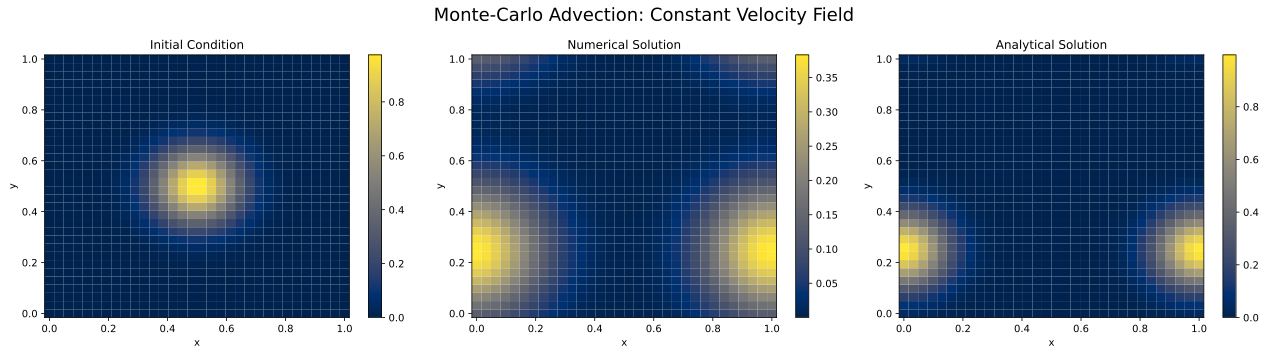

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fields = [initial_field, field, exact_field]
titles = ['Initial Condition', 'Numerical Solution', 'Analytical Solution']

for ax, data, title in zip(axes, fields, titles):
    im = ax.pcolormesh(X, Y, data, cmap='cividis', shading='auto')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

fig.suptitle('Monte-Carlo Advection: Constant Velocity Field', fontsize=18)
plt.tight_layout()
show_plot()

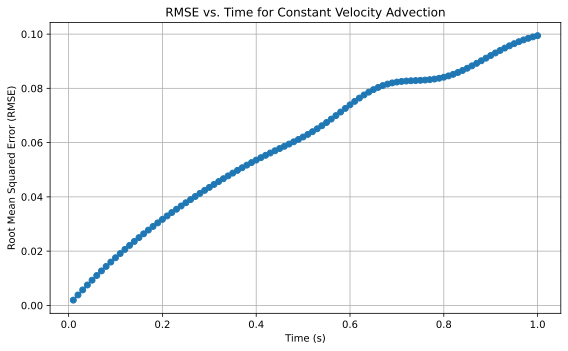

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, rmse_list, marker='o')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_title('RMSE vs. Time for Constant Velocity Advection')
ax.grid(True)
plt.tight_layout()
show_plot()

In [31]:
rmse_value = np.sqrt(np.mean((field - exact_field) ** 2))
print(f"Root Mean Squared Error (constant field): {rmse_value:.2e}")

Root Mean Squared Error (constant field): 9.94e-02


In [32]:
initial_rotating_field = initialize_gaussian(0.7, 0.5, 0.05, X, Y)
rotating_field = initial_rotating_field.copy()

TIME_STEP = 0.01
TOTAL_TIME = 2 * np.pi
num_steps = int(TOTAL_TIME / TIME_STEP)

for _ in range(num_steps):
    u_rot, v_rot = rotating_velocity_field(X, Y)
    rotating_field = monte_carlo_advect_2d(
        rotating_field, u_rot, v_rot, TIME_STEP
        )

rmse_rot = np.sqrt(np.mean((rotating_field - initial_rotating_field) ** 2))

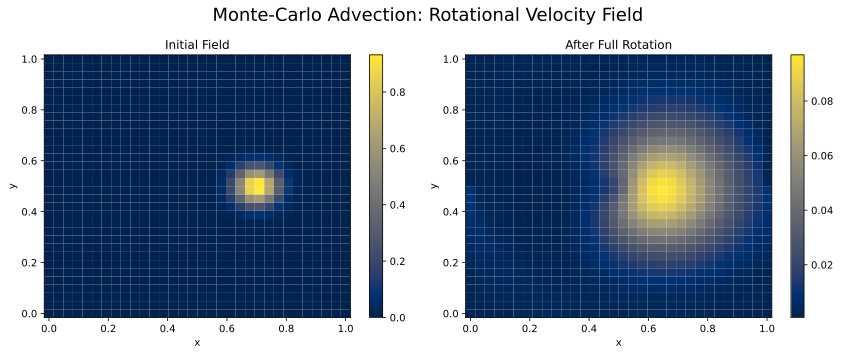

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fields_rot = [initial_rotating_field, rotating_field]
titles_rot = ['Initial Field', 'After Full Rotation']

for ax, data, title in zip(axes, fields_rot, titles_rot):
    im = ax.pcolormesh(X, Y, data, cmap='cividis', shading='auto')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

fig.suptitle('Monte-Carlo Advection: Rotational Velocity Field', fontsize=18)
plt.tight_layout()
show_plot()

In [34]:
print(f"Root Mean Squared Error (Molenkamp test): {rmse_rot:.2e}")

Root Mean Squared Error (Molenkamp test): 7.46e-02


## Assignment Goal

The objective of this assignment is to extend the Monte-Carlo advection solver to a two-dimensional 32×32 grid, implementing both a constant-in-time velocity field and a rotating velocity field (Molenkamp test). The focus is on the correctness of the implementation, comparison of numerical results with analytical solutions, and the quality of visualization and code formatting.

## Approach

1. The Monte-Carlo advection solver was generalized to two spatial dimensions.
2. Two types of velocity fields were defined:
   - a constant velocity field `(u, v) = (0.5, 0.75)`,
   - a rotational, non-divergent velocity field that rotates the signal around the domain center (Molenkamp test).
3. Initial conditions were chosen as localized Gaussian distributions:
   - centered at the domain center for simple advection testing,
   - off-center for the rotational Molenkamp test.
4. Numerical results were compared to analytical solutions through:
   - exact displacement of the Gaussian shape in the constant flow case, where the analytical solution involved shifting the initial condition along the velocity vector;
   - reconstruction of the initial distribution after one or multiple full rotations in the Molenkamp test.
   Quantitative evaluation was performed by computing the root mean squared error (RMSE) between the numerical solution and the analytical reference. Low RMSE values indicated good agreement and validated the numerical method’s accuracy.

## Conclusions

The two-dimensional Monte-Carlo advection method successfully replicates both simple linear advection and complex rotation under a non-divergent flow. After one full rotation, the observed error remains small, demonstrating the solver’s correctness and robustness. Some numerical diffusion and slight smoothing of the scalar field are observed, especially after several rotations, which is expected due to interpolation errors and sampling noise inherent to the Monte-Carlo method. Nevertheless, the method retains the primary characteristics of the initial distribution, confirming its effectiveness for modeling advective transport processes.

Additionally, the RMSE evolution over time for the constant velocity advection case was analyzed. The RMSE exhibits a gradual and smooth increase during the simulation, reaching approximately 0.10 at the final time. This trend reflects the expected cumulative effects of numerical diffusion and interpolation errors inherent to the Monte-Carlo approach. The consistent and controlled growth of RMSE further confirms the solver's stability and its ability to maintain solution accuracy over long advection periods.